In [6]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt

from qiskit import Aer
from tqdm.notebook import tqdm
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import multiprocessing as mp

import sys
sys.path.insert(0, '../../src/')
from neuralnetwork import *
from analysis import *

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def parallel(args):
    model = args[0]
    x = args[1]
    y = args[2]
    verbose = args[3]
    
    model.train(x, y, verbose = verbose)
    
    return model

# Boston Housing Data

### Load Data

In [8]:
data = load_boston()
x = data.data
x_scaled = scaler(x, mode="standard")

y = data.target.reshape(-1, 1)
y = scaler(y, a=0, b=1)

## PCA

In [9]:
pca = PCA(n_components=4)
x_pca = pca.fit_transform(x_scaled)

In [10]:
x_qcn = scaler(x_pca, a=-np.pi/2, b=np.pi/2)
x_dnn = scaler(x_pca, mode="standard")

np.random.seed(42)
x_train_qcn, x_test_qcn, y_train, y_test = train_test_split(x_qcn, y, train_size=100, test_size=100)
np.random.seed(42)
x_train_dnn, x_test_dnn, y_train, y_test = train_test_split(x_dnn, y, train_size=100, test_size=100)

## DNN

  0%|          | 0/10 [00:00<?, ?it/s]

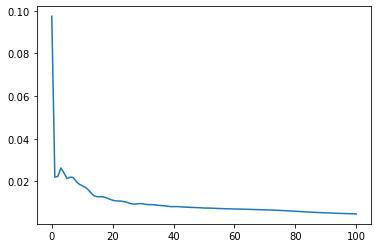

In [13]:
np.random.seed(42)

dnn_list = []
for i in tqdm(range(10)):
    dnn = sequential_dnn(dim = [4, 5, 1])
    dnn.train(x_train_dnn, y_train, epochs = 100)
    dnn_list.append(dnn)
    
saver(dnn_list, data_path("boston_dnn_pca"))
plt.plot(dnn_list[0].loss)
plt.show()

In [14]:
print(dnn_list[7].loss[-1])

y_pred = dnn_list[0].predict(x_test_dnn)
loss = np.mean((y_pred - y_test)**2)
print(loss)

0.005581761577954132
0.013560693876755382


## QCN

In [ ]:
np.random.seed(42)
qcn_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = [4, 4],
                         dim = [4, 4, 1],
                         encoder= Encoder(),
                         ansatz = Ansatz(blocks = ["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         cost = MSE(),
                         optimizer = Adam(lr=0.1),
                         shots=0)
    
    qcn_list.append([qcn, x_train_qcn, y_train, False])

qcn_list[0][3] = True    
    
with mp.Pool(10) as p:
    qcn_list = p.map(parallel, qcn_list)     
    
saver(qcn_list, data_path("boston_qcn"))

In [11]:
qcn_list = loader(data_path("boston_qcn"))
qcn_list[4].loss[-1]

0.004448898634523595

In [12]:
qcn_list = loader(data_path("boston_qcn"))

y_pred = qcn_list[4].predict(x_test_qcn)
loss = np.mean((y_pred - y_test)**2)
print(loss)

0.01542856638712062


## Hybrid

In [3]:
data = load_boston()
x = data.data
x_scaled = scaler(x, mode="standard")

y = data.target.reshape(-1, 1)
y = scaler(y, a=0, b=1)

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, train_size=100, test_size=100)

In [4]:
np.random.seed(42)
hybrid_list = []
for i in range(10):
    layer1 = Dense(n_features = 13, 
                   n_targets = 4,
                   activation = Tanh(),
                   scale=np.pi)

    layer2 = QLayer(n_qubits = 4,
                    n_features = 4, 
                    n_targets = 4, 
                    encoder = Encoder(), 
                    ansatz = Ansatz(blocks = ["entangle", "ry"], reps=2),
                    sampler=Parity(),
                    shots=0)

    layer3 = QLayer(n_qubits = 4,
                    n_features = 4, 
                    n_targets = 1, 
                    encoder = Encoder(), 
                    ansatz = Ansatz(blocks = ["entangle", "ry"], reps=2),
                    sampler=Parity(),
                    shots=0)

    layers = [layer1, layer2, layer3]
    hybrid = NeuralNetwork(layers)
    
    hybrid_list.append([hybrid, x_train, y_train, False])

hybrid_list[0][3] = True    
    
with mp.Pool(10) as p:
    hybrid_list = p.map(parallel, hybrid_list)     
    
saver(hybrid_list, data_path("boston_hybrid"))

epoch: 0, loss: 0.08094445181935711
epoch: 1, loss: 0.04430139091471586
epoch: 2, loss: 0.04104623898302903
epoch: 3, loss: 0.03427491433839565
epoch: 4, loss: 0.03379318669585971
epoch: 5, loss: 0.03152923445378866
epoch: 6, loss: 0.028273221413863903
epoch: 7, loss: 0.0257601287509094
epoch: 8, loss: 0.024544366442578673
epoch: 9, loss: 0.02396476393658406
epoch: 10, loss: 0.02273546121795646
epoch: 11, loss: 0.02165854369000865
epoch: 12, loss: 0.021174715952551118
epoch: 13, loss: 0.02081952765350094
epoch: 14, loss: 0.019343210151085966
epoch: 15, loss: 0.01804258416592602
epoch: 16, loss: 0.017961632583743833
epoch: 17, loss: 0.017986743903271124
epoch: 18, loss: 0.017480213437854823
epoch: 19, loss: 0.016723541367531635
epoch: 20, loss: 0.015844677252690273
epoch: 21, loss: 0.01480547605136676
epoch: 22, loss: 0.014108761463250373
epoch: 23, loss: 0.013990363149577342
epoch: 24, loss: 0.013851762462249163
epoch: 25, loss: 0.013495983907331992
epoch: 26, loss: 0.01305231034390054

In [ ]:
print(hybrid_list[0].loss[-1])
y_pred = hybrid_list[0].predict(x_test)
loss = np.mean((y_pred - y_test)**2)
print(loss)

In [ ]:
np.random.seed(42)

dnn_list = []
for i in tqdm(range(10)):
    dnn = sequential_dnn(dim = [13, 5, 5, 1])
    dnn.train(x_train, y_train, epochs = 100)
    dnn_list.append(dnn)
    
saver(dnn_list, data_path("boston_dnn_full"))
plt.plot(dnn_list[0].loss)
plt.show()

In [ ]:
print(dnn_list[0].loss[-1])
y_pred = dnn_list[0].predict(x_test)
loss = np.mean((y_pred - y_test)**2)
print(loss)